In [152]:
import json
import numpy as np
import pandas as pd
from pathlib import Path

notebooks_dir = Path.cwd()
project_dir = notebooks_dir.parent
data_dir = project_dir / 'data' / 'raw'
text_data_path = data_dir / 'Subtask_2_train.json'
interim_dir = project_dir / 'data' / 'interim'
mel_dir = interim_dir / 'mel' 

# Prepare text data

In [153]:
text_data = json.loads(text_data_path.read_text())
for i in range(len(text_data[0]['conversation'])):
    print(text_data[0]['conversation'][i])

{'utterance_ID': 1, 'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .', 'speaker': 'Chandler', 'emotion': 'neutral', 'video_name': 'dia1utt1.mp4'}
{'utterance_ID': 2, 'text': 'Oh , yeah . Had that dream .', 'speaker': 'All', 'emotion': 'neutral', 'video_name': 'dia1utt2.mp4'}
{'utterance_ID': 3, 'text': 'Then I look down , and I realize there is a phone ... there .', 'speaker': 'Chandler', 'emotion': 'surprise', 'video_name': 'dia1utt3.mp4'}
{'utterance_ID': 4, 'text': 'Instead of ... ?', 'speaker': 'Joey', 'emotion': 'surprise', 'video_name': 'dia1utt4.mp4'}
{'utterance_ID': 5, 'text': 'That is right .', 'speaker': 'Chandler', 'emotion': 'anger', 'video_name': 'dia1utt5.mp4'}
{'utterance_ID': 6, 'text': 'Never had that dream .', 'speaker': 'Joey', 'emotion': 'neutral', 'video_name': 'dia1utt6.mp4'}
{'utterance_ID': 7, 'text': 'No .', 'speaker': 'Phoebe', 'emotion': 'neutral', 'video_name': 'dia1utt7.mp4'}

Load data from JSON file

In [154]:
def get_conversation_from_json(json_convo):
    convo = []
    emotions = []
    filenames = []
    speakers = []
    for line_idx in range(len(json_convo)):
        convo += [json_convo[line_idx]['text']]
        emotions += [json_convo[line_idx]['emotion']]
        filenames += [json_convo[line_idx]['video_name'][:-4]]
        speakers += [json_convo[line_idx]['speaker']]
    return convo, emotions, filenames, speakers

convos = []
all_emotions = []
all_filenames = []
all_speakers = []
for convo_idx in range(len(text_data)):
    convo, emotions, filenames, speakers = get_conversation_from_json(text_data[convo_idx]['conversation'])
    convos += convo
    all_emotions += emotions
    all_filenames += filenames
    all_speakers += speakers

data_dict = {'filename': all_filenames, 'conversation' : convos, 'emotion': all_emotions, 'speaker': all_speakers}

In [155]:
import pandas as pd

df = pd.DataFrame(data_dict)
df.head()

,filename,conversation,emotion,speaker
0,dia1utt1,"Alright , so I am back in high school , I am s...",neutral,Chandler
1,dia1utt2,"Oh , yeah . Had that dream .",neutral,All
2,dia1utt3,"Then I look down , and I realize there is a ph...",surprise,Chandler
3,dia1utt4,Instead of ... ?,surprise,Joey
4,dia1utt5,That is right .,anger,Chandler


Fix contractions in text

In [156]:
import contractions

def fix_contractions(doc):
    # expand contractions
    doc = contractions.fix(doc)
    return doc

#df['fixed_conversation'] = df['conversation'].apply(lambda convo: fix_contractions(convo))

all_filenames = df['filename'].tolist()
#all_text = df['fixed_conversation'].tolist()
all_text = df['conversation'].tolist()
all_labels = df['emotion'].tolist()
all_speakers = df['speaker'].tolist()

Split into train/val/test following the given file split which matches the audio split

also load mel spectograms

In [167]:
from skimage import io

X_train_text = []
X_train_speaker = []
X_train_mel = []
y_train_text = []


pathlist = (mel_dir / 'train').rglob('*.tiff')

for path in pathlist:
    extra = len(str(mel_dir / 'train'))+1
    str_path = str(path)
    fname = str_path[extra:-5] 
    idx = all_filenames.index(fname)
    text = all_text[idx]
    label = all_emotions[idx]
    speaker = all_speakers[idx]

    mel = io.imread(path)
    X_train_mel.append(mel)
    
    X_train_text.append(text)
    X_train_speaker.append(speaker)
    y_train_text.append(label)

In [158]:
X_val_text = []
X_val_speaker = []
X_val_mel = []
y_val_text = []

pathlist = (mel_dir / 'dev').rglob('*.tiff')

for path in pathlist:
    extra = len(str(mel_dir / 'dev'))+1
    str_path = str(path)
    fname = str_path[extra:-5] 
    idx = all_filenames.index(fname)
    text = all_text[idx]
    label = all_emotions[idx]
    speaker = all_speakers[idx]

    mel = io.imread(path)
    X_val_mel.append(mel)
    
    X_val_text.append(text)
    X_val_speaker.append(speaker)
    y_val_text.append(label)

In [159]:
X_test_text = []
X_test_speaker = []
X_test_mel = []
y_test_text = []

pathlist = (mel_dir / 'test').rglob('*.tiff')

for path in pathlist:
    extra = len(str(mel_dir / 'test'))+1
    str_path = str(path)
    fname = str_path[extra:-5] 
    idx = all_filenames.index(fname)
    text = all_text[idx]
    label = all_emotions[idx]
    speaker = all_speakers[idx]

    mel = io.imread(path)
    X_test_mel.append(mel)
    
    X_test_text.append(text)
    X_test_speaker.append(speaker)
    y_test_text.append(label)

In [173]:
X_train_text = np.asarray(X_train_text)
X_train_mel = np.asarray(X_train_mel)
X_train_speaker = np.asarray(X_train_speaker)
y_train_text = np.asarray(y_train_text)

print(f'Shape of X_train_text: {X_train_text.shape}')
print(f'Shape of X_train_mel: {X_train_mel.shape}')
print(f'Shape of X_train_speaker: {X_train_speaker.shape}')
print(f'Shape of y_train_text: {y_train_text.shape}')

Shape of X_train_text: (9966,)
Shape of X_train_mel: (9966, 128, 128)
Shape of X_train_speaker: (9966,)
Shape of y_train_text: (9966,)


In [176]:
X_val_text = np.asarray(X_val_text)
X_val_mel = np.asarray(X_val_mel)
X_val_speaker = np.asarray(X_val_speaker)
y_val_text = np.asarray(y_val_text)

X_test_text = np.asarray(X_test_text)
X_test_mel = np.asarray(X_test_mel)
X_test_speaker = np.asarray(X_test_speaker)
y_test_text = np.asarray(y_test_text)

print(f'Shape of X_val_text: {X_val_text.shape}')
print(f'Shape of X_val_mel: {X_val_mel.shape}')
print(f'Shape of X_val_speaker: {X_val_speaker.shape}')
print(f'Shape of y_val_text: {y_val_text.shape}')

print(f'Shape of X_test_text: {X_test_text.shape}')
print(f'Shape of X_test_mel: {X_test_mel.shape}')
print(f'Shape of X_test_speaker: {X_test_speaker.shape}')
print(f'Shape of y_test_text: {y_test_text.shape}')

Shape of X_val_text: (1087,)
Shape of X_val_mel: (1087, 128, 128)
Shape of X_val_speaker: (1087,)
Shape of y_val_text: (1087,)
Shape of X_test_text: (2566,)
Shape of X_test_mel: (2566, 128, 128)
Shape of X_test_speaker: (2566,)
Shape of y_test_text: (2566,)


Prepare labels

In [177]:
import tensorflow as tf

labels = ['neutral', 'joy', 'surprise', 'anger', 'fear', 'disgust', 'sadness']
num_classes = len(labels)
label_to_index = {label: index for index, label in enumerate(labels)}
index_to_label = {index: label for index, label in enumerate(labels)}

train_idx_label = [label_to_index[label] for label in y_train_text]
y_train_text_onehot = tf.one_hot(train_idx_label, len(labels)).numpy()

val_idx_label = [label_to_index[label] for label in y_val_text]
y_val_text_onehot = tf.one_hot(val_idx_label, len(labels)).numpy()

test_idx_label = [label_to_index[label] for label in y_test_text]
y_test_text_onehot = tf.one_hot(test_idx_label, len(labels)).numpy()

Import BERT model

In [178]:
import tensorflow_hub as hub
import tensorflow as tf
from bert.tokenization import FullTokenizer     
from tensorflow.keras.models import Model
import os

#os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

MAX_LEN = 50
hub_link = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/1"
max_seq_length = MAX_LEN
num_classes = len(labels)

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,),
                                       dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,),
                                   dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,),
                                    dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer(hub_link,
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

dense_layer1 = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
dense_layer2 = tf.keras.layers.Dense(num_classes, activation='softmax')(dense_layer1)

#model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=dense_layer2) for fine tuning

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [179]:
bert_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 50, 768)]                 'input_mask[0][0]',      

Preprocessing helpers for BERT

In [180]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        #print(len(tokens))
        #raise IndexError("Token length more than max seq length!")
        tokens = tokens[:max_seq_length]
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        #raise IndexError("Token length more than max seq length!")
        tokens = tokens[:max_seq_length]
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    if len(tokens) > max_seq_length:
        tokens = tokens[:max_seq_length]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

Preprocess text for BERT

In [181]:
def preprocess_text(X):
    tokenized_X = [tokenizer.tokenize(text) for text in X]
    input_ids = [get_ids(tokens, tokenizer, max_seq_length) for tokens in tokenized_X]
    input_masks = [get_masks(tokens, max_seq_length) for tokens in tokenized_X]
    input_segments = [get_segments(tokens, max_seq_length) for tokens in tokenized_X]

    return np.array(input_ids), np.array(input_masks), np.array(input_segments)

In [182]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [183]:
train_input_ids, train_input_masks, train_input_segments = preprocess_text(X_train_text)
val_input_ids, val_input_masks, val_input_segments = preprocess_text(X_val_text)
test_input_ids, test_input_masks, test_input_segments = preprocess_text(X_test_text)

Get BERT embeddings

In [184]:
pool_embs_train, all_embs_train = bert_model.predict(
    x={"input_word_ids": train_input_ids,
       "input_mask": train_input_masks,
       "segment_ids": train_input_segments})

pool_embs_val, all_embs_val = bert_model.predict(
    x={"input_word_ids": val_input_ids,
       "input_mask": val_input_masks,
       "segment_ids": val_input_segments})

pool_embs_test, all_embs_test = bert_model.predict(
    x={"input_word_ids": test_input_ids,
       "input_mask": test_input_masks,
       "segment_ids": test_input_segments})

2024-04-17 17:10:19.849364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 34s 426ms/step


In [185]:
print(f"Shape of pooled output: {pool_embs_train.shape}")
print(f"Shape of all embeddings output: {all_embs_train.shape}")

Shape of pooled output: (9966, 768)
Shape of all embeddings output: (9966, 50, 768)


# Logistic Regression text baseline 

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_train_int = np.argmax(y_train_text_onehot, axis=1)
y_val_int = np.argmax(y_val_text_onehot, axis=1)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(pool_embs_train, y_train_int)

train_accuracy = logreg.score(pool_embs_train, y_train_int)

predictions = logreg.predict(pool_embs_val)
accuracy = accuracy_score(y_val_int, predictions)
print("Train accuracy:", train_accuracy)
print("Validation accuracy:", accuracy)

Train accuracy: 0.6173991571342565
Validation accuracy: 0.5234590616375345


In [187]:
y_test_int = np.argmax(y_test_text_onehot, axis=1)
test_accuracy = logreg.score(pool_embs_test, y_test_int)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.5381917381137958


PCA + scaling

In [274]:
logreg_ = LogisticRegression(max_iter=1000)
logreg_.fit(pca_embs_train, y_train_int)
print("Train accuracy:", logreg_.score(pca_embs_train, y_train_int))
print("Validation accuracy:", logreg_.score(pca_embs_val, y_val_int))

Train accuracy: 0.6084687938992575
Validation accuracy: 0.5179392824287029


In [275]:
logreg_ = LogisticRegression(max_iter=1000)
logreg_.fit(scaled_embs_train, y_train_int)
print("Train accuracy:", logreg_.score(scaled_embs_train, y_train_int))
print("Validation accuracy:", logreg_.score(scaled_embs_val, y_val_int))

Train accuracy: 0.6162954043748746
Validation accuracy: 0.516099356025759


# Naive Bayes

In [269]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
pca.fit(pool_embs_train)
pca_embs_train = pca.transform(pool_embs_train)

In [270]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(pca_embs_train)
scaled_embs_train = scaler.transform(pca_embs_train)

In [271]:
from sklearn.naive_bayes import ComplementNB
nb = ComplementNB()
nb.fit(X=scaled_embs_train, y=y_train_int)

ComplementNB()

In [272]:
train_accuracy = nb.score(scaled_embs_train, y_train_int)
print("Train accuracy:", train_accuracy)

Train accuracy: 0.5583985550872969


In [273]:
pca_embs_val = pca.transform(pool_embs_val)
scaled_embs_val = scaler.transform(pca_embs_val)
val_accuracy = nb.score(scaled_embs_val, y_val_int)
print("Validation accuracy:", val_accuracy)

pca_embs_test = pca.transform(pool_embs_test)
scaled_embs_test = scaler.transform(pca_embs_test)
test_accuracy = nb.score(scaled_embs_test, y_test_int)
print("Test accuracy:", test_accuracy)

Validation accuracy: 0.5087396504139834
Test accuracy: 0.5054559625876851


# MLP on text

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers 

def create_mlp(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(1024, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [61]:
from sklearn.utils.class_weight import compute_class_weight

input_dim = 768
num_classes = 7

mlp_model = create_mlp(input_dim, num_classes)

y_train_integers = np.argmax(y_train_text_onehot, axis=1)

mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 768)]             0         
                                                                 
 dense_45 (Dense)            (None, 512)               393728    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_47 (Dense)            (None, 128)               328

In [40]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train_integers), 
                                     y=y_train_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 0.32438238453276047, 1: 0.8335563733690198, 2: 1.0430141287284145, 3: 1.2488721804511278, 4: 5.196037539103233, 5: 4.729947793070717, 6: 1.8044541010320478}


In [62]:
history = mlp_model.fit(x=pool_embs_train, 
                        y=y_train_text_onehot, 
                        validation_data=(pool_embs_val, y_val_text_onehot),
                        batch_size=32,
                        epochs=50,
                        class_weight=d_class_weights)

Epoch 1/50


2024-04-15 18:14:16.754136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - ETA: 0s - loss: 1.9745 - accuracy: 0.2446

2024-04-15 18:14:27.697752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 13s 31ms/step - loss: 1.9745 - accuracy: 0.2446 - val_loss: 1.9768 - val_accuracy: 0.2475
Epoch 2/50
312/312 [==============================] - 7s 21ms/step - loss: 1.7974 - accuracy: 0.3023 - val_loss: 1.8772 - val_accuracy: 0.2668
Epoch 3/50
312/312 [==============================] - 6s 21ms/step - loss: 1.7533 - accuracy: 0.3314 - val_loss: 1.7677 - val_accuracy: 0.3284
Epoch 4/50
312/312 [==============================] - 6s 21ms/step - loss: 1.7202 - accuracy: 0.3432 - val_loss: 1.7796 - val_accuracy: 0.3358
Epoch 5/50
312/312 [==============================] - 6s 20ms/step - loss: 1.6924 - accuracy: 0.3583 - val_loss: 1.8616 - val_accuracy: 0.3376
Epoch 6/50
312/312 [==============================] - 7s 21ms/step - loss: 1.6793 - accuracy: 0.3634 - val_loss: 2.0018 - val_accuracy: 0.2272
Epoch 7/50
312/312 [==============================] - 7s 21ms/step - loss: 1.6516 - accuracy: 0.3647 - val_loss: 2.0030 - val_accuracy: 0.2429
Epoch 8/5

## results

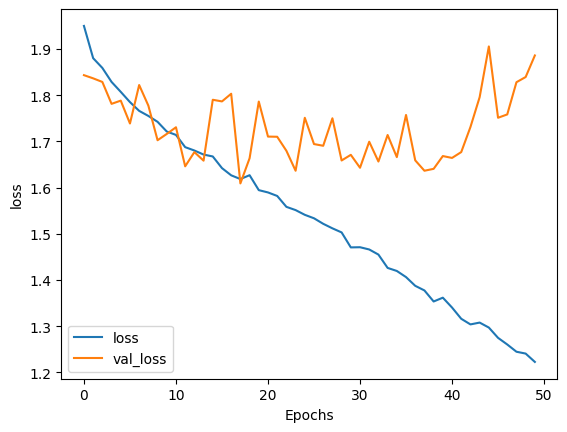

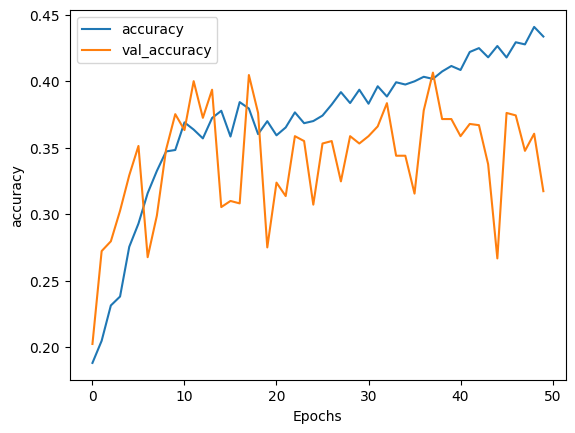

In [57]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_graphs(history,'loss')
plot_graphs(history,'accuracy')

# GRU with all text embeddings

In [78]:
from tensorflow.keras import layers 
from tensorflow.keras.models import Model

def create_gru_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(inputs)
    x = layers.Bidirectional(layers.GRU(128))(x)
    
    x = layers.Dropout(0.5)(x)

    #x = layers.Dense(512, activation='relu')(x)

    x = layers.Dense(256, activation='relu')(x)
    
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [79]:
bert_output_dim = 768

input_shape = (max_seq_length, bert_output_dim)  
num_classes = 7 

gru_model = create_gru_model(input_shape, num_classes)

gru_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


gru_history = gru_model.fit(all_embs_train, 
                            y_train_text_onehot, 
                            batch_size=32, 
                            epochs=15, 
                            validation_data=(
                                all_embs_val, 
                                y_val_text_onehot),
                            class_weight=d_class_weights
                            )

Epoch 1/15


2024-04-15 20:10:22.232689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:23.220112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:23.283651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:30.862900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:30.902685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:38.573853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:10:38.594561: I tensorflow/core/grappler/optimizers/cust

312/312 [==============================] - ETA: 0s - loss: 2.0548 - accuracy: 0.2053

2024-04-15 20:12:10.025786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:12:10.523511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:12:10.595199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:12:18.178593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-04-15 20:12:18.203654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 159s 376ms/step - loss: 2.0548 - accuracy: 0.2053 - val_loss: 1.8772 - val_accuracy: 0.2714
Epoch 2/15
312/312 [==============================] - 57s 180ms/step - loss: 1.8613 - accuracy: 0.2823 - val_loss: 1.6802 - val_accuracy: 0.3597
Epoch 3/15
312/312 [==============================] - 58s 185ms/step - loss: 1.7766 - accuracy: 0.3359 - val_loss: 1.6278 - val_accuracy: 0.4002
Epoch 4/15
312/312 [==============================] - 60s 191ms/step - loss: 1.7280 - accuracy: 0.3738 - val_loss: 1.6847 - val_accuracy: 0.3542
Epoch 5/15
312/312 [==============================] - 74s 238ms/step - loss: 1.6722 - accuracy: 0.3716 - val_loss: 1.6583 - val_accuracy: 0.3597
Epoch 6/15
312/312 [==============================] - 81s 258ms/step - loss: 1.6098 - accuracy: 0.3862 - val_loss: 1.5744 - val_accuracy: 0.4204
Epoch 7/15
312/312 [==============================] - 64s 204ms/step - loss: 1.5967 - accuracy: 0.4020 - val_loss: 1.5539 - val_accuracy: 0.

## results

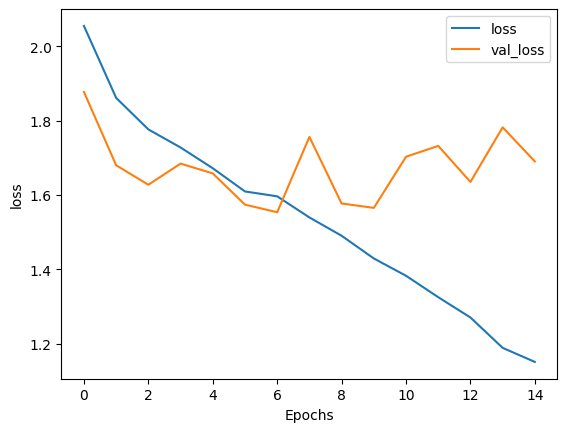

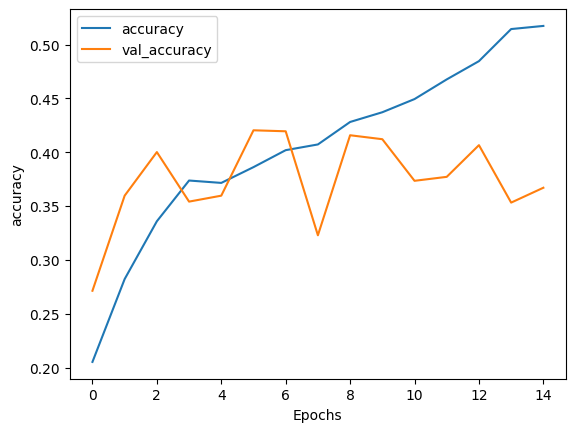

In [88]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_graphs(gru_history,'loss')
plot_graphs(gru_history,'accuracy')

# Speaker info

In [143]:
class CrossAttentionLayer(layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(CrossAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim

    def build(self, input_shape):
        self.query = layers.Dense(self.key_dim)
        self.key = layers.Dense(self.key_dim)
        self.value = layers.Dense(self.key_dim)
        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.key_dim // self.num_heads
        )

    def call(self, inputs):
        text_embeddings, speaker_embedding = inputs

        query = tf.expand_dims(self.query(speaker_embedding), axis=1)
        key = tf.expand_dims(self.key(text_embeddings), axis=1)
        value = tf.expand_dims(self.value(text_embeddings), axis=1)

        attention_output = self.mha(query=query, value=value, key=key)
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape[0][0], input_shape[0][1], self.key_dim

In [145]:
num_heads = 8
key_dim = 64
#speaker_embed_dim = 64

def create_speaker_model(bert_output_dim, num_classes, num_speakers):
    text_input = layers.Input(shape=(bert_output_dim,))
    speaker_input = layers.Input(shape=(1,))
    inputs = (text_input, speaker_input)

    

    #reduced_text_input = layers.Dense(key_dim)(text_input)
    
    speaker_embedding = layers.Embedding(
        input_dim=num_speakers, 
        output_dim=key_dim
        )(speaker_input)
    speaker_embedding = layers.Flatten()(speaker_embedding)

    #cross_attention = CrossAttentionLayer(
    #    num_heads=num_heads, 
    #    key_dim=key_dim)([reduced_text_input, speaker_embedding])
    
    #flat_cross_attention = layers.Flatten()(cross_attention)

    #x = layers.Dense(512, activation='relu')(flat_cross_attention)

    combined_features = layers.Concatenate()([text_input, speaker_embedding])

    x = layers.Dense(512, activation='relu')(combined_features)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model


In [146]:
bert_output_dim = 768
num_classes = 7
num_speakers = len(np.unique(X_train_speaker))

speaker_model = create_speaker_model(bert_output_dim, num_classes, num_speakers)

speaker_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

speaker_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_58 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 64)        16960       ['input_58[0][0]']               
                                                                                                  
 input_57 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 flatten_15 (Flatten)           (None, 64)           0           ['embedding_16[0][0]']           
                                                                                           

prepare speaker labels

In [188]:
speaker_mapping = {label: idx for idx, label in enumerate(np.unique(X_train_speaker))}

X_train_speaker_encoded = np.array([speaker_mapping[label] for label in X_train_speaker])
X_val_speaker_encoded = np.array([speaker_mapping.get(label, -1) for label in X_val_speaker])  
X_test_speaker_encoded = np.array([speaker_mapping.get(label, -1) for label in X_test_speaker]) 


In [147]:
speaker_history = speaker_model.fit(
    x=(pool_embs_train, X_train_speaker_encoded), 
    y=y_train_text_onehot, 
    validation_data=((pool_embs_val, X_val_speaker_encoded), 
                     y_val_text_onehot),
    batch_size=32,
    epochs=30,
    class_weight=d_class_weights)

Epoch 1/30


2024-04-15 22:08:13.344849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - ETA: 0s - loss: 1.9645 - accuracy: 0.2532

2024-04-15 22:08:25.001554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 14s 35ms/step - loss: 1.9645 - accuracy: 0.2532 - val_loss: 1.7384 - val_accuracy: 0.3661
Epoch 2/30
312/312 [==============================] - 9s 29ms/step - loss: 1.7971 - accuracy: 0.3142 - val_loss: 1.8153 - val_accuracy: 0.2999
Epoch 3/30
312/312 [==============================] - 8s 27ms/step - loss: 1.7377 - accuracy: 0.3540 - val_loss: 1.9466 - val_accuracy: 0.2429
Epoch 4/30
312/312 [==============================] - 8s 25ms/step - loss: 1.6936 - accuracy: 0.3539 - val_loss: 1.8778 - val_accuracy: 0.2732
Epoch 5/30
312/312 [==============================] - 7s 23ms/step - loss: 1.6520 - accuracy: 0.3711 - val_loss: 1.8405 - val_accuracy: 0.2695
Epoch 6/30
312/312 [==============================] - 8s 25ms/step - loss: 1.6088 - accuracy: 0.3856 - val_loss: 1.7752 - val_accuracy: 0.3128
Epoch 7/30
312/312 [==============================] - 8s 26ms/step - loss: 1.5810 - accuracy: 0.3905 - val_loss: 1.6646 - val_accuracy: 0.4434
Epoch 8/3

results

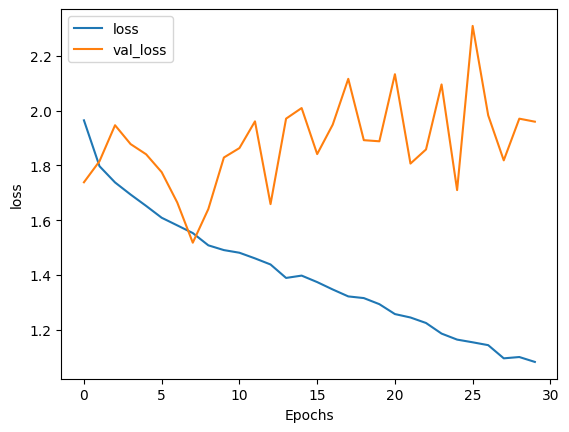

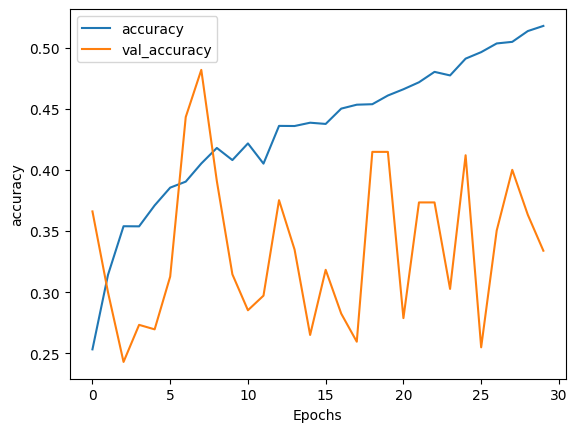

In [149]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_graphs(speaker_history,'loss')
plot_graphs(speaker_history,'accuracy')

# Text-Audio with Cross-Attention

In [190]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(
            query=x, value=y,
            return_attention_scores=True
        )

        self.last_attention_scores = attention_scores

        x = self.add([x, attn])
        return self.layernorm(x)

In [232]:
def create_crossattention_model(bert_output_dim, audio_output_dim, num_classes, num_heads, key_dim):
    audio_x, audio_y, num_channels = audio_output_dim
    text_input = layers.Input(shape=(bert_output_dim,))
    audio_input = layers.Input(shape=(audio_x, audio_y, num_channels,))

    audio_conv = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(audio_input)
    audio_pool = tf.keras.layers.GlobalAveragePooling2D()(audio_conv)

    audio_pool_reshaped = tf.keras.layers.Reshape((1, -1))(audio_pool)
    text_input_reshaped = tf.keras.layers.Reshape((1, -1))(text_input)

    text_to_audio_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=key_dim
    )(x=text_input_reshaped, y=audio_pool_reshaped)

    audio_to_text_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=key_dim
    )(x=audio_pool_reshaped, y=text_input_reshaped)

    concatenated_attention = layers.Concatenate()([text_to_audio_attention, audio_to_text_attention])
    _, _, num_features = concatenated_attention.shape
    reshaped_attn = tf.keras.layers.Reshape((-1,))(concatenated_attention)

    x = layers.Dense(512, activation='relu')(reshaped_attn)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[text_input, audio_input], outputs=outputs)
    return model

In [233]:
bert_output_dim = 768
audio_output_dim = (128,128,1)
num_classes = 7
num_heads = 8
key_dim = 64

crossattention_model = create_crossattention_model(bert_output_dim, audio_output_dim, num_classes, num_heads, key_dim)
crossattention_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_96 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 126, 126, 64  640         ['input_96[0][0]']               
                                )                                                                 
                                                                                                  
 input_95 (InputLayer)          [(None, 768)]        0           []                               
                                                                                           

In [236]:
from tensorflow.keras.utils import plot_model

plot_model(crossattention_model, show_shapes=True, show_layer_names=True) # requires graphvis

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [237]:
crossattention_model.compile(optimizer='adam',
                             loss='categorical_crossentropy', 
                             metrics=['accuracy'])

crossattention_history = crossattention_model.fit(
    x=(pool_embs_train, X_train_mel), 
    y=y_train_text_onehot, 
    validation_data=((pool_embs_val, X_val_mel), 
                     y_val_text_onehot),
    batch_size=32,
    epochs=30,
    class_weight=d_class_weights)

Epoch 1/30


2024-04-17 18:17:02.138814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - ETA: 0s - loss: 1.9740 - accuracy: 0.2496

2024-04-17 18:17:53.548439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 58s 134ms/step - loss: 1.9740 - accuracy: 0.2496 - val_loss: 2.1291 - val_accuracy: 0.1987
Epoch 2/30
312/312 [==============================] - 41s 131ms/step - loss: 1.8059 - accuracy: 0.2983 - val_loss: 1.7659 - val_accuracy: 0.3542
Epoch 3/30
312/312 [==============================] - 40s 127ms/step - loss: 1.7550 - accuracy: 0.3351 - val_loss: 1.7851 - val_accuracy: 0.2760
Epoch 4/30
312/312 [==============================] - 39s 124ms/step - loss: 1.7316 - accuracy: 0.3363 - val_loss: 2.3127 - val_accuracy: 0.1684
Epoch 5/30
312/312 [==============================] - 39s 124ms/step - loss: 1.6941 - accuracy: 0.3528 - val_loss: 1.6701 - val_accuracy: 0.3468
Epoch 6/30
312/312 [==============================] - 38s 122ms/step - loss: 1.6684 - accuracy: 0.3527 - val_loss: 1.7736 - val_accuracy: 0.3201
Epoch 7/30
312/312 [==============================] - 38s 122ms/step - loss: 1.6487 - accuracy: 0.3621 - val_loss: 2.1229 - val_accuracy: 0.2

KeyboardInterrupt: 